In [1]:
import pandas as pd

In [2]:
# Path to raw Truth Social dump (TSV format)
path = "/Users/sargun/Desktop/truth social/truth_social/truths.tsv"

# Read TSV file
# - engine="python" handles irregular quoting
# - on_bad_lines="skip" drops malformed rows safely
df = pd.read_csv(
    path,
    sep="\t",
    engine="python",       
    on_bad_lines="skip"    
)

print(df.shape)
df.columns

(739779, 13)


Index(['id', 'timestamp', 'time_scraped', 'is_retruth', 'is_reply', 'author',
       'like_count', 'retruth_count', 'reply_count', 'text', 'external_id',
       'url', 'truth_retruthed'],
      dtype='str')

In [3]:
# Keep only author, timestamp, and post text
columns = ['author','timestamp','text']
df_new = df[columns].copy()

In [4]:
df_new.head()

,author,timestamp,text
0,2247,2022-05-14 00:00:00,Q+ BE READY ANONS - PUBLIC AWAKENING COMING - ...
1,20054,2022-03-27 00:00:00,Enough is enough! RETRUTH
2,20054,2022-03-29 00:00:00,https://justthenews.com/politics-policy/all-th...
3,20054,2022-03-29 00:00:00,https://t.me/realx22report/6729
4,20054,2022-03-29 00:00:00,@CeceBloomwood


In [5]:
# Convert timestamp column to pandas datetime
# Invalid timestamps become NaT
df_new["timestamp"] = pd.to_datetime(df_new["timestamp"], errors="coerce")

In [6]:
df_new[["timestamp"]].head()

,timestamp
0,2022-05-14
1,2022-03-27
2,2022-03-29
3,2022-03-29
4,2022-03-29


In [7]:
# Count invalid timestamps
df_new["timestamp"].isna().sum()

np.int64(60788)

In [8]:
# Drop rows missing author or text
df_text = df_new.dropna(subset=["author", "text"]).copy()

# Concatenate all posts per author into one long string
# used for stylometric (writing-style) features
user_text = df_text.groupby("author")["text"].apply(lambda s: " ".join(map(str, s))).reset_index()

In [9]:
print("users:", len(user_text), "rows:", len(df_text))
user_text.head()

users: 14853 rows: 739777


,author,text
0,22,RETRACTO #368: Utah NPR Affiliate RETRACTS Fal...
1,23,"<emoji: pray> Thank you for sharing, Carrie <e..."
2,24,#TheSecretCurriculum UPDATE: Trinity School DE...
3,25,Battle of the Bulge 1944.
4,26,100% cc. Lara Trump If Trump were to create a ...


In [11]:
# Stylometric feature extraction
# (Character n-gram TF-IDF)

import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

# Character-level TF-IDF captures writing style
# (spelling, punctuation, emoji usage, etc.)
tfidf = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3, 5), # short character patterns
    min_df=3,
    max_df=0.9,
    lowercase=False, # preserve casing style
)

# Sparse TF-IDF matrix (users × char-ngrams)
X = tfidf.fit_transform(user_text["text"])

# Dimensionality reduction

# stylistic latent dimensions
k_svd = 50 

# Truncated SVD for dense stylometric embedding
svd = TruncatedSVD(n_components=k_svd, random_state=42)

# Normalize vectors to unit length (cosine space)
pipe = make_pipeline(svd, Normalizer(copy=False))

X_ling = pipe.fit_transform(X)  # (n_users, k_svd), L2-normalized

# Identify users with near-zero vectors
norms = np.linalg.norm(X_ling, axis=1)
keep = norms > 1e-12

if keep.mean() < 1.0:
    print("Dropping zero-norm users:", int((~keep).sum()))

# Filter out degenerate users
X_ling = X_ling[keep]
authors_kept = user_text.loc[keep, "author"].values



Dropping zero-norm users: 9


In [12]:
# Build stylometric feature table
ling_df = pd.DataFrame(
    X_ling,
    columns=[f"ling_{i}" for i in range(X_ling.shape[1])]
)
ling_df.insert(0, "author", authors_kept)



In [13]:
len(ling_df)

14844

In [16]:
from sklearn.metrics import silhouette_score

for k in range(4, 10):
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X_ling)
    score = silhouette_score(X_ling, labels)
    print(k, score)

4 0.16849928677415874
5 0.1819624865127418
6 0.14371913913401746
7 0.09343093198393732
8 0.0938739925923171
9 0.10348607591340457


In [17]:
# Stylometric clustering
from sklearn.cluster import KMeans

# KMeans clusters for writing style groups
k_clusters = 5
km_l = KMeans(n_clusters=k_clusters, random_state=42, n_init="auto")
ling_df["kmeans_ling"] = km_l.fit_predict(X_ling)

In [18]:
ling_df.head()

,author,ling_0,ling_1,ling_2,ling_3,ling_4,ling_5,ling_6,ling_7,ling_8,...,ling_41,ling_42,ling_43,ling_44,ling_45,ling_46,ling_47,ling_48,ling_49,kmeans_ling
0,22,0.781459,-0.271391,0.379891,-0.069229,-0.031515,0.004439,-0.021703,0.010158,0.021356,...,-0.132517,-0.041883,0.084456,-0.028263,0.006805,-0.004642,0.070131,0.018400,0.037578,4
1,23,0.721756,0.369159,0.172723,-0.037770,-0.147258,0.084441,0.011738,-0.040734,-0.108233,...,-0.050033,-0.083943,0.088018,-0.085199,0.022597,0.002440,-0.024489,-0.017250,0.031144,1
2,24,0.714187,-0.253721,0.404419,-0.060392,-0.008740,0.003632,-0.035353,-0.003940,0.088341,...,-0.058721,0.006418,0.049154,0.010357,-0.005755,-0.007051,0.062816,0.031150,0.005726,3
3,25,0.410468,-0.245082,-0.152917,-0.052663,-0.024418,-0.001386,-0.047309,-0.000961,0.040924,...,-0.025968,0.096279,0.054815,-0.032668,-0.008286,0.120160,0.103309,-0.002199,-0.128958,4
4,26,0.912956,-0.019679,-0.062488,-0.014918,-0.129251,0.111727,-0.080715,-0.057530,0.130026,...,0.017330,0.040583,0.010841,-0.057752,0.018717,-0.013968,-0.045622,-0.019742,-0.070318,4


In [19]:
!pip install hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 1.2 MB/s  0:00:01 eta 0:00:01


In [21]:
# Density-based clustering (allows "noise" users)
import hdbscan
hdb_l = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5)
ling_df["hdb_ling"] = hdb_l.fit_predict(X_ling)

### Linguistic (Stylometric) Clustering
We cluster users based on linguistic style using character-level stylometric embeddings (ling_*), which capture punctuation, casing, emoji usage, and other writing habits. Dimensionality-reduced TF-IDF character n-gram representations are clustered using both centroid-based (KMeans) and density-based (HDBSCAN) methods. This analysis reveals distinct stylistic groups as well as a small number of highly distinctive or outlier writing styles.

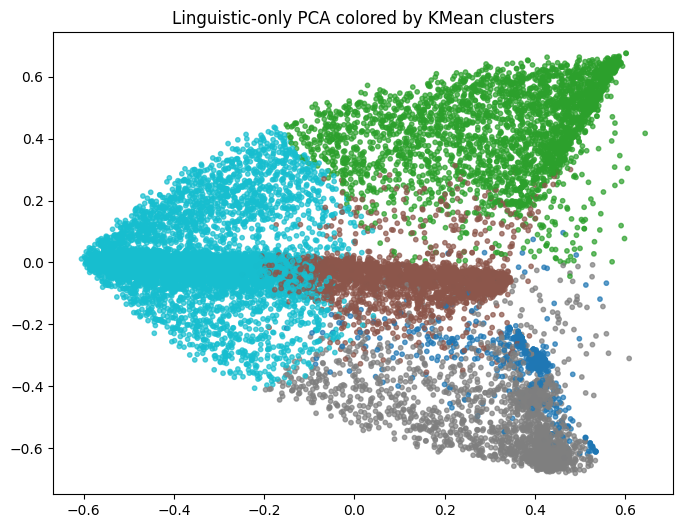

In [19]:
# Stylometric cluster visualization

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 2D PCA projection for visualization only
Z_l = PCA(n_components=2, random_state=42).fit_transform(X_ling)
plt.figure(figsize=(8,6))
plt.scatter(Z_l[:,0], Z_l[:,1], c=ling_df["kmeans_ling"], s=10, cmap="tab10", alpha=0.7)
plt.title("Linguistic-only PCA colored by KMean clusters")
plt.show()

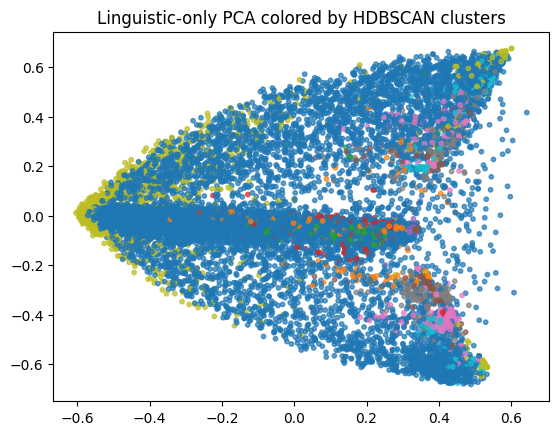

In [22]:
# HDBSCAN visualization (-1 = noise)
labels = ling_df["hdb_ling"]
colors = np.where(labels == -1, -1, labels)

plt.scatter(
    Z_l[:,0],
    Z_l[:,1],
    c=colors,
    s=10,
    cmap="tab10",
    alpha=0.7
)

plt.title("Linguistic-only PCA colored by HDBSCAN clusters")
plt.show()


In [27]:
# Temporal behavior features

# Keep only valid author–timestamp pairs
df_time = df_new.dropna(subset=["author", "timestamp"]).copy()
df_time = df_time.dropna(subset=["timestamp"])

# Basic temporal bins
df_time["month"] = df_time["timestamp"].dt.month          # 1..12
df_time["dow"] = df_time["timestamp"].dt.dayofweek        # 0..6
df_time["date"] = df_time["timestamp"].dt.date            # day resolution

# Posting rhythm histograms

# Monthly posting distribution per user
month_counts = (
    df_time.groupby(["author", "month"]).size()
    .unstack(fill_value=0)
    .reindex(columns=range(1, 13), fill_value=0)
)
month_props = month_counts.div(month_counts.sum(axis=1), axis=0)
month_props.columns = [f"temp_month_{m:02d}" for m in month_props.columns]

# Day-of-week posting distribution per user)
dow_counts = (
    df_time.groupby(["author", "dow"]).size()
    .unstack(fill_value=0)
    .reindex(columns=range(0, 7), fill_value=0)
)
dow_props = dow_counts.div(dow_counts.sum(axis=1), axis=0)
dow_props.columns = [f"temp_dow_{d}" for d in dow_props.columns]

# Activity statistics


agg = df_time.groupby("author").agg(
    n_posts=("timestamp", "size"),
    first_ts=("timestamp", "min"),
    last_ts=("timestamp", "max"),
    active_days=("date", "nunique"),
)

# Posting lifespan
agg["span_days"] = (agg["last_ts"] - agg["first_ts"]).dt.days

# Posting intensity
agg["posts_per_active_day"] = agg["n_posts"] / agg["active_days"].clip(lower=1)

# Combine all temporal features
temp_df = pd.concat([month_props, dow_props, agg[["n_posts","active_days","span_days","posts_per_active_day"]]], axis=1).reset_index()
temp_df.head()


,author,temp_month_01,temp_month_02,temp_month_03,temp_month_04,temp_month_05,temp_month_06,temp_month_07,temp_month_08,temp_month_09,...,temp_dow_1,temp_dow_2,temp_dow_3,temp_dow_4,temp_dow_5,temp_dow_6,n_posts,active_days,span_days,posts_per_active_day
0,22,0.0,0.00000,0.0,0.00000,0.000000,0.615385,0.307692,0.000000,0.076923,...,0.230769,0.153846,0.153846,0.153846,0.076923,0.153846,13,10,77,1.300000
1,23,0.0,0.00000,0.0,0.00000,0.007353,0.041667,0.051471,0.161765,0.294118,...,0.210784,0.250000,0.188725,0.100490,0.019608,0.007353,408,67,144,6.089552
2,24,0.0,0.00000,0.0,0.00000,0.000000,0.253333,0.053333,0.226667,0.466667,...,0.173333,0.293333,0.266667,0.146667,0.053333,0.013333,75,34,87,2.205882
3,26,0.0,0.00000,0.8,0.20000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.200000,0.800000,0.000000,0.000000,0.000000,0.000000,5,2,5,2.500000
4,27,0.0,0.00123,0.0,0.00615,0.044280,0.050431,0.277983,0.432964,0.179582,...,0.195572,0.162362,0.118081,0.146371,0.115621,0.150062,813,107,241,7.598131


In [30]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

for k in range(2, 9):
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X_temp)
    score = silhouette_score(X_temp, labels)
    print(f"k={k}, silhouette={score:.4f}")

k=2, silhouette=0.2644
k=3, silhouette=0.1200
k=4, silhouette=0.1148
k=5, silhouette=0.1359
k=6, silhouette=0.1352
k=7, silhouette=0.1514
k=8, silhouette=0.0634


In [31]:
# Temporal clustering
from sklearn.preprocessing import StandardScaler
temp_cols = [c for c in temp_df.columns if c.startswith("temp_")]
X_temp = StandardScaler().fit_transform(temp_df[temp_cols].to_numpy(dtype=np.float32))

k = 2
km_t = KMeans(n_clusters=k, random_state=42, n_init="auto")
temp_df["kmeans_temp"] = km_t.fit_predict(X_temp)

In [32]:
temp_df["hdb_temp"] = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5).fit_predict(X_temp)

### Temporal Rhythm Clustering

Temporal rhythm clustering focuses on when users post, independent of posting volume. We use normalized month-of-year and day-of-week histograms (temp_*) to capture seasonal and weekly posting patterns. Density-based clustering is performed using HDBSCAN with min_cluster_size = 10 and min_samples = 5, allowing detection of tightly synchronized posting schedules while conservatively labeling the majority of users as noise, indicating a largely continuous temporal activity space.

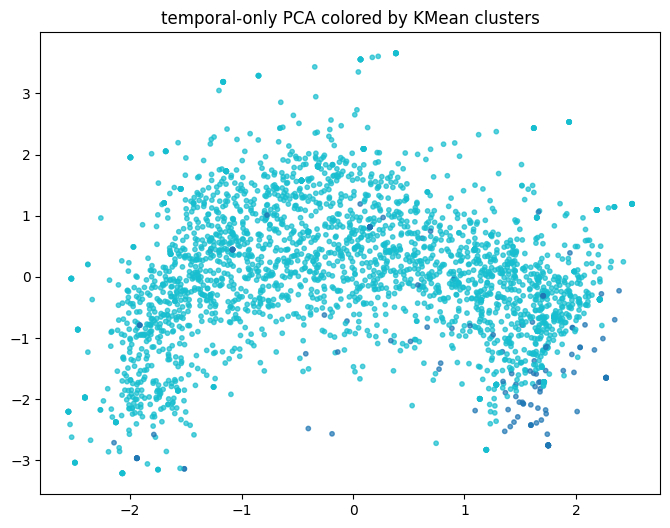

In [33]:
# Temporal PCA visualization
Z_t = PCA(n_components=2, random_state=42).fit_transform(X_temp)
plt.figure(figsize=(8,6))
plt.scatter(Z_t[:,0], Z_t[:,1], c=temp_df["kmeans_temp"], s=10, cmap="tab10", alpha=0.7)
plt.title("temporal-only PCA colored by KMean clusters")
plt.show()

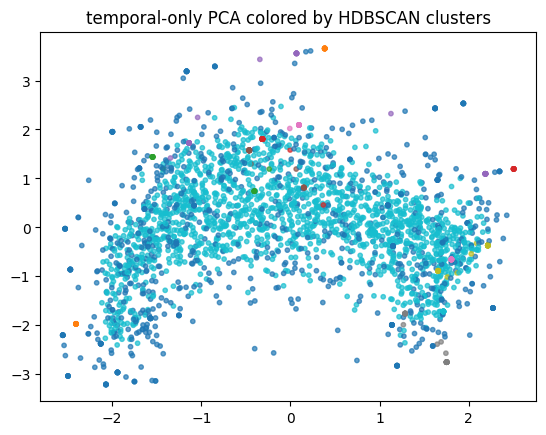

In [34]:
labels = temp_df["hdb_temp"]
colors = np.where(labels == -1, -1, labels)

plt.scatter(
    Z_t[:,0],
    Z_t[:,1],
    c=colors,
    s=10,
    cmap="tab10",
    alpha=0.7
)

plt.title("temporal-only PCA colored by HDBSCAN clusters")
plt.show()

In [35]:
np.unique(temp_df["hdb_temp"], return_counts=True)


(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18]),
 array([ 893,   13,   10,   10,   12,   10,   10,   21,   13,   23,   19,
          14,   16,   12,   11,   18,   16,   25,   17, 1601]))

In [38]:
# Activity-only clustering
activity_cols = ["n_posts","active_days","span_days","posts_per_active_day"]
X_activity = StandardScaler().fit_transform(temp_df[activity_cols].to_numpy(dtype=np.float32))

# Silhouette evaluation
for k in range(2, 9):
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X_activity)
    score = silhouette_score(X_activity, labels)
    print(f"k={k}, silhouette={score:.4f}")


k=2, silhouette=0.5191
k=3, silhouette=0.4783
k=4, silhouette=0.5080
k=5, silhouette=0.5108
k=6, silhouette=0.5035
k=7, silhouette=0.4498
k=8, silhouette=0.4641


In [60]:
k = 4
km_t = KMeans(n_clusters=k, random_state=42, n_init="auto")
temp_df["kmeans_activity"] = km_t.fit_predict(X_activity)

In [40]:
temp_df["hdb_activity"] = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=3).fit_predict(X_activity)

### Activity Intensity Clustering
Activity clustering captures how much and how long users post, using aggregate statistics including total post count, number of active days, activity span, and posts per active day. HDBSCAN is applied with min_cluster_size = 5 and min_samples = 3, identifying small groups of highly active or bursty users while avoiding forced partitioning of the broader user population. This separation highlights differences in engagement intensity rather than posting schedule or linguistic style.

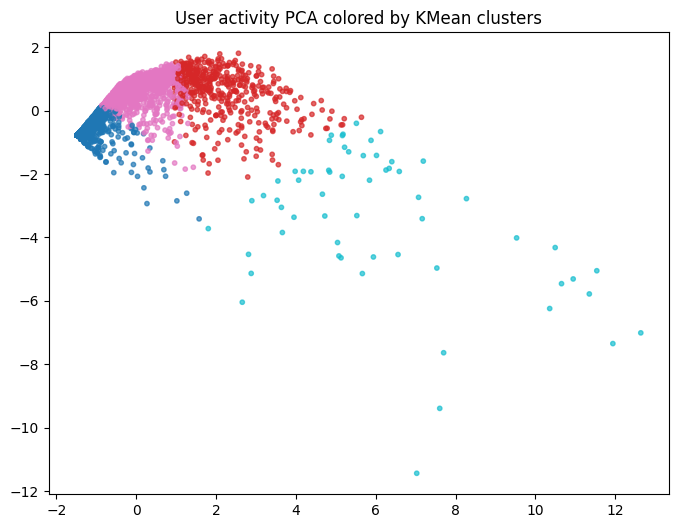

In [61]:

Z_a = PCA(n_components=2, random_state=42).fit_transform(X_activity)
plt.figure(figsize=(8,6))
plt.scatter(Z_a[:,0], Z_a[:,1], c=temp_df["kmeans_activity"], s=10, cmap="tab10", alpha=0.7)
plt.title("User activity PCA colored by KMean clusters")
plt.show()

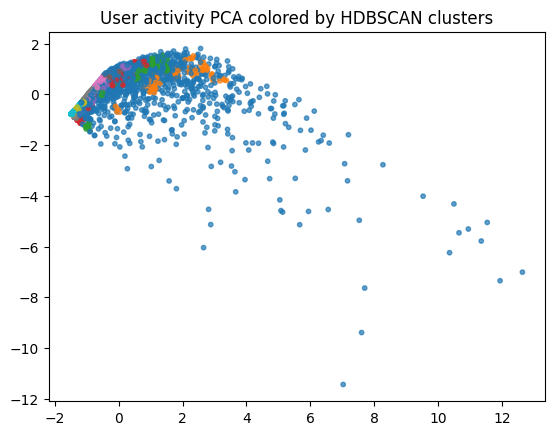

In [43]:
labels = temp_df["hdb_activity"]
colors = np.where(labels == -1, -1, labels)

plt.scatter(
    Z_a[:,0],
    Z_a[:,1],
    c=colors,
    s=10,
    cmap="tab10",
    alpha=0.7
)

plt.title("User activity PCA colored by HDBSCAN clusters")
plt.show()

In [65]:
path_ = "/Users/sargun/Desktop/truth social/truthsocial_user_features.csv"
df_clean = pd.read_csv(path_)

In [81]:
path_ = "/Users/sargun/Desktop/truth social/truthsocial_features_new.csv"
df_clean_ = pd.read_csv(path_)

In [89]:
df_clean['topic_label'].isna().sum()

np.int64(0)

In [85]:
df_clean_.head()

,id,timestamp,author,like_count,retruth_count,reply_count,text,hate_pred,hate_prob,sentiment_id,...,statement_flag,statement_probability,TRUTH_CLASS_x,NO_STMT,TRUE,FALSE,clusters,topic_label,style_cluster,activity_cluster
0,703265,13,2247,0,0,0,q+ be ready anons - public awakening coming - ...,0,0.005426,1,...,0,0.010807,NaN,NaN,NaN,NaN,"[5, 5, 5, 5, 5, 5]",Prayer or Spiritual Support,4.0,2.0
1,807614,6,20054,0,0,0,enough is enough! retruth,0,0.001936,1,...,0,0.029001,NaN,NaN,NaN,NaN,[5],Patriot Appreciation,4.0,2.0
2,807621,6,20054,0,0,0,joe biden wants this video removed from the in...,0,0.015105,0,...,1,0.519844,0.0,0.943432,0.020946,0.035622,[5],Ukraine Russia Conflict,4.0,2.0
3,807622,6,20054,0,0,0,<emoji: dart><emoji: 100><emoji: us>,0,0.003288,1,...,0,0.011909,NaN,NaN,NaN,NaN,[5],Prayer or Spiritual Support,4.0,2.0
4,807625,5,20054,0,0,0,#truth #soros #ukraine,0,0.142274,1,...,0,0.035824,NaN,NaN,NaN,NaN,[5],Ukraine Russia Conflict,4.0,2.0


In [67]:
df_clean = df_clean.drop(['temporal_rhythm_cluster', 'activity_cluster', 'style_cluster'], axis=1)

In [69]:
# Merge clusters back to post-level data

# Map stylometric cluster to each author
styl_map = ling_df[["author", "kmeans_ling"]].rename(
    columns={"kmeans_ling": "style_cluster"}
)

In [70]:
df_clean = df_clean.merge(styl_map, on="author", how="left")

In [71]:
df_clean["style_cluster"].value_counts(dropna=False)

style_cluster
4.0    367056
1.0    149050
3.0     75170
2.0      2652
NaN      1626
0.0      1204
Name: count, dtype: int64

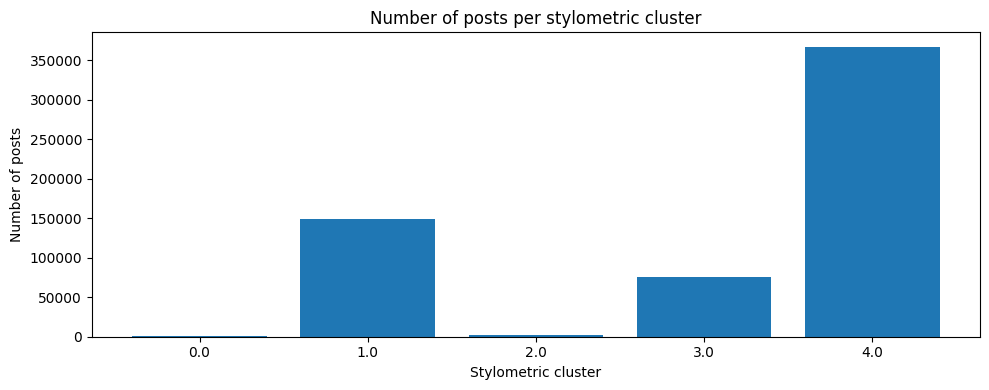

In [72]:
counts = (
    df_clean["style_cluster"]
    .value_counts()
    .sort_index()
)

plt.figure(figsize=(10,4))
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel("Stylometric cluster")
plt.ylabel("Number of posts")
plt.title("Number of posts per stylometric cluster")
plt.tight_layout()
plt.show()


In [73]:
# Activity + temporal clusters
temp_map = temp_df[["author", "kmeans_activity", "kmeans_temp"]].rename(
    columns={"kmeans_activity": "activity_cluster","kmeans_temp": "temporal_rhythm_cluster"}
)
df_clean = df_clean.merge(temp_map, on="author", how="left")


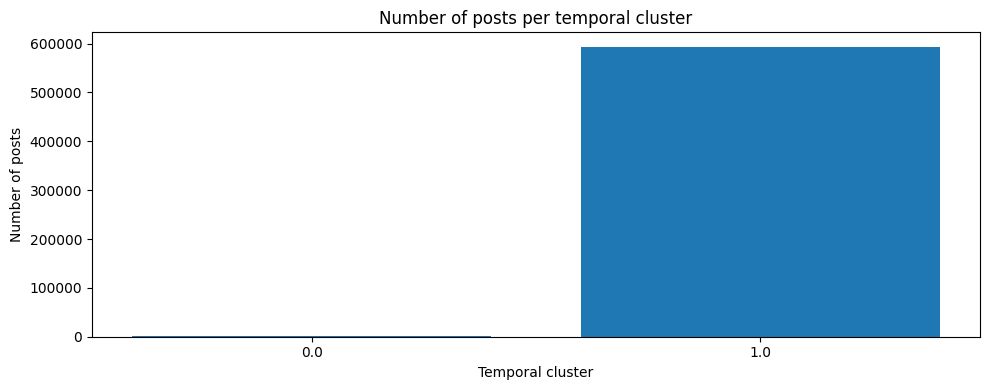

In [74]:
counts = (
    df_clean["temporal_rhythm_cluster"]
    .value_counts()
    .sort_index()
)

plt.figure(figsize=(10,4))
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel("Temporal cluster")
plt.ylabel("Number of posts")
plt.title("Number of posts per temporal cluster")
plt.tight_layout()
plt.show()

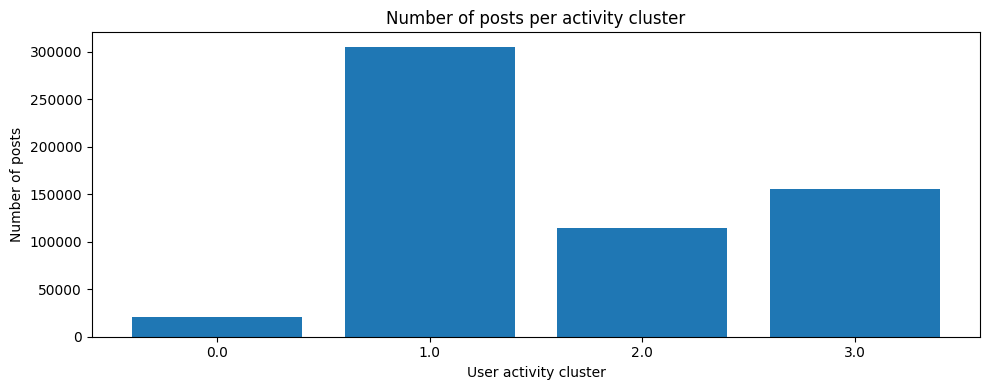

In [79]:
counts = (
    df_clean["activity_cluster"]
    .value_counts()
    .sort_index()
)

plt.figure(figsize=(10,4))
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel("User activity cluster")
plt.ylabel("Number of posts")
plt.title("Number of posts per activity cluster")
plt.tight_layout()
plt.show()

In [78]:
df_clean.head()

,id,timestamp,author,like_count,retruth_count,reply_count,text,hate_pred,hate_prob,sentiment_id,...,statement_flag,statement_probability,TRUTH_CLASS_x,NO_STMT,TRUE,FALSE,clusters,topic_label,style_cluster,activity_cluster
0,703265,13,2247,0,0,0,q+ be ready anons - public awakening coming - ...,0,0.005426,1,...,0,0.010807,NaN,NaN,NaN,NaN,"[5, 5, 5, 5, 5, 5]",Prayer or Spiritual Support,4.0,2.0
1,807614,6,20054,0,0,0,enough is enough! retruth,0,0.001936,1,...,0,0.029001,NaN,NaN,NaN,NaN,[5],Patriot Appreciation,4.0,2.0
2,807621,6,20054,0,0,0,joe biden wants this video removed from the in...,0,0.015105,0,...,1,0.519844,0.0,0.943432,0.020946,0.035622,[5],Ukraine Russia Conflict,4.0,2.0
3,807622,6,20054,0,0,0,<emoji: dart><emoji: 100><emoji: us>,0,0.003288,1,...,0,0.011909,NaN,NaN,NaN,NaN,[5],Prayer or Spiritual Support,4.0,2.0
4,807625,5,20054,0,0,0,#truth #soros #ukraine,0,0.142274,1,...,0,0.035824,NaN,NaN,NaN,NaN,[5],Ukraine Russia Conflict,4.0,2.0


In [77]:
df_clean = df_clean.drop(['temporal_rhythm_cluster'], axis=1)

In [80]:
# Save final dataset

out_path = "truthsocial_features_new.csv"
df_clean.to_csv(out_path, index=False)
print("Saved:", out_path)

Saved: truthsocial_features_new.csv


In [ ]:
# Final GNN node feature table

In [152]:
# Merge linguistic + temporal features at user level
gnn_nodes_df = ling_df.merge(
    temp_df,
    on="author",
    how="inner"   
)

In [156]:
cols_to_drop = [
    "kmeans_temp", "hdb_temp",
    "kmeans_temp_activity", "hdb_temp_activity", "kmeans_activity", "hdb_activity"
]

gnn_nodes_df = gnn_nodes_df.drop(columns=cols_to_drop, errors="ignore")


In [157]:
gnn_nodes_df.head()

,author,ling_0,ling_1,ling_2,ling_3,ling_4,ling_5,ling_6,ling_7,ling_8,...,temp_dow_1,temp_dow_2,temp_dow_3,temp_dow_4,temp_dow_5,temp_dow_6,n_posts,active_days,span_days,posts_per_active_day
0,22,0.741996,0.225452,-0.118673,-0.068565,0.081678,-0.054224,0.010780,-0.142340,0.129227,...,0.230769,0.153846,0.153846,0.153846,0.076923,0.153846,13,10,77,1.300000
1,23,0.633004,0.474433,-0.186685,0.034253,-0.006141,-0.040407,0.106117,-0.062942,0.127114,...,0.210784,0.250000,0.188725,0.100490,0.019608,0.007353,408,67,144,6.089552
2,24,0.772140,-0.207723,-0.010159,-0.151647,0.254120,0.001382,-0.081946,-0.281395,0.057089,...,0.173333,0.293333,0.266667,0.146667,0.053333,0.013333,75,34,87,2.205882
3,26,0.875806,0.189344,-0.188182,-0.034686,0.180305,-0.014024,-0.013900,0.115020,0.103352,...,0.200000,0.800000,0.000000,0.000000,0.000000,0.000000,5,2,5,2.500000
4,27,0.878580,-0.385420,0.025275,-0.155682,0.099169,-0.014501,0.088361,0.137470,-0.059246,...,0.195572,0.162362,0.118081,0.146371,0.115621,0.150062,813,107,241,7.598131
